In [4]:
using Plots, Colors, DataFrames, CSV, GLM, Statistics
using BenchmarkTools, SparseArrays

cd("/Users/junwong/Dropbox/Second Year/Dingel - Trade/Assignments")

# Calibrating sector level data

In [5]:
df = DataFrame(CSV.File("data/bilateral_trade_country/bilateral_trade_sector_country.csv"));


In [6]:
# Total destination sector; collapse to country-origin/dest + sector-origin level
Xₙᵢʲ = combine(groupby(df, [:country_org, :country_dest, :sector_org]), :trade_flow2014 => sum, renamecols=false);
rename!(Xₙᵢʲ, :trade_flow2014 => :X_ni_j0)

# Total spending by sector in country n 
total_spending_sectororg = combine(groupby(Xₙᵢʲ, [:country_dest, :sector_org]), :X_ni_j0 => sum, renamecols=false);
rename!(total_spending_sectororg, :X_ni_j0 => :spending_sectororg)

# πₙᵢʲ = Xₙᵢʲ / ∑ₒ Xₙₒʲ
Xₙᵢʲ = leftjoin(Xₙᵢʲ, total_spending_sectororg, on=[:country_dest, :sector_org])
transform!(Xₙᵢʲ, [:X_ni_j0, :spending_sectororg] => (./) => :pi_ni_j);

df = leftjoin(df, Xₙᵢʲ, on=[:country_org, :country_dest, :sector_org]);


Compute $\gamma$

In [7]:
# Total revenue of sector k in country n = ∑ᵢ Xᵢₙᵏ
revenue_by_sectororg = combine(groupby(Xₙᵢʲ, [:country_org, :sector_org]), :X_ni_j0 => sum, renamecols=false)
rename!(revenue_by_sectororg, [:country_org, :sector_org, :X_ni_j0] .=> [:country, :sector_dest, :revenue_sectororg])

# Purchases of sector k in country n on goods of sector j = ∑ᵢ Xₙᵢʲᵏ
cross_sector_spending = combine(groupby(df, [:country_dest, :sector_dest, :sector_org]), :trade_flow2014 => sum, renamecols=false)
rename!(cross_sector_spending, [:country_dest, :trade_flow2014] .=> [:country, :spending_cross_sector])

# γₙʲᵏ = ∑ᵢ Xₙᵢʲᵏ / ∑ᵢ Xᵢₙᵏ
cross_sector_spending = innerjoin(cross_sector_spending, revenue_by_sectororg, on=[:country, :sector_dest])
transform!(cross_sector_spending, [:spending_cross_sector, :revenue_sectororg] => (./) => :gamma_n_jk)

# Impute γ with average of sector pairs (j,k) across countries 
nm_cross_sector = filter(:gamma_n_jk => x -> !(ismissing(x) || isnan(x)), cross_sector_spending)
nm_cross_sector = combine(groupby(nm_cross_sector, [:sector_org, :sector_dest]), :gamma_n_jk => mean)
cross_sector_spending = leftjoin(cross_sector_spending, nm_cross_sector, on=[:sector_org, :sector_dest])
for row in eachrow(cross_sector_spending)
    row[:gamma_n_jk] = ifelse(isnan(row[:gamma_n_jk]), row[:gamma_n_jk_mean], row[:gamma_n_jk])
end

# Find average γ across countries 
γ̄ʲᵏ = combine(groupby(cross_sector_spending, [:sector_dest, :sector_org]), :gamma_n_jk => mean);


Defining share value added in production

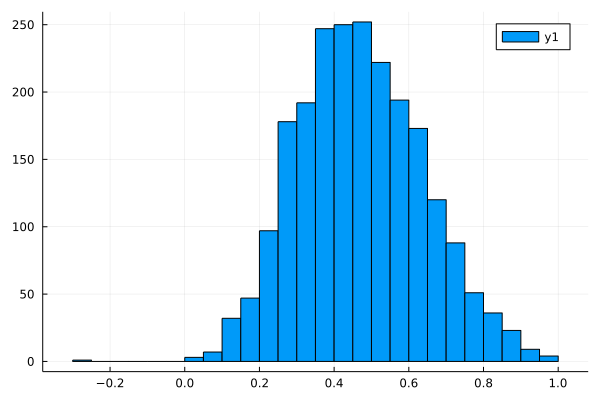

In [8]:
# ∑ⱼ γₙʲᵏ
gamma_sectdest = combine(groupby(cross_sector_spending, [:country, :sector_dest]), :gamma_n_jk => sum)

# γₙᵏ = 1 - ∑ⱼ γₙʲᵏ
gamma_sectdest[!, :gamma_n_k] = 1 .- gamma_sectdest[!,:gamma_n_jk_sum];

# Average value added 
avg_value_added_share = combine(groupby(gamma_sectdest, :sector_dest), :gamma_n_k => mean);

histogram(gamma_sectdest[!,:gamma_n_k])


Value added in initial equilibrium 

In [9]:
va⁰ = leftjoin(Xₙᵢʲ, gamma_sectdest, on=[:country_dest => :country, :sector_org => :sector_dest])
transform!(va⁰, [:gamma_n_k, :X_ni_j0] => (.*) => :value_added);
va⁰ = combine(groupby(va⁰, :country_dest), :value_added => sum, renamecols=false);


International transfers

In [10]:
# ∑ₒₖ Xₒₙᵏ
d1 = combine(groupby(df, :country_org), :trade_flow2014 => sum)
rename!(d1, :trade_flow2014_sum => :sum_x_on_k)

# ∑ₒₖ Xₙₒᵏ
d2 = combine(groupby(df, :country_dest), :trade_flow2014 => sum)
rename!(d2, :trade_flow2014_sum => :sum_x_no_k)

# h(w) Dₙ = ∑ₒₖ Xₙₒᵏ - ∑ₒₖ Xₒₙᵏ
transfers = innerjoin(d1, d2, on= :country_org => :country_dest)
transform!(transfers, [:sum_x_no_k, :sum_x_on_k] => (.-) => :transfer)

# Transfer as share of value added 
transfer_shares = innerjoin(transfers, va⁰, on= :country_org => :country_dest);



Final spending shares

In [11]:
# Rₙ⁰ = 0 since no tariff at baseline 

# ∑ᵢ Xₙᵢʲ is just total spending at destination across different origin sectors = total_spending_sectororg[!, :spending_sectororg]

# ∑ₖ ∑ₒ γₙʲᵏ * Xₒₙᵏ: I think you should start with df
num = innerjoin(cross_sector_spending, Xₙᵢʲ, on=[:country => :country_org, :sector_dest => :sector_org])
transform!(num, [:X_ni_j0, :gamma_n_jk] => (.*) => :numerator)
num = combine(groupby(num, [:country, :sector_org]), :numerator => sum, renamecols = false)
select!(num, [:country, :sector_org, :numerator])

# αₙʲ = (∑ᵢ Xₙᵢʲ - ∑ₖ ∑ₒ γₙʲᵏ * Xₒₙᵏ) / (Rₙ⁰ + wₙLₙ + h(w) Dₙ) 
num = innerjoin(num, transfer_shares, on=:country => :country_org)
num = innerjoin(num, total_spending_sectororg, on=[:country => :country_dest, :sector_org => :sector_org])
num.alpha_n_j = (num.spending_sectororg .- num.numerator) ./ (num.value_added .+ num.transfer);
#num.denom = num.value_added .+ num.sum_x_no_k .+ num.transfer;

# ᾱʲ 
avg_alpha = combine(groupby(num, [:sector_org]), :alpha_n_j => mean)
CSV.write("output/avg_alpha_j.csv", avg_alpha)

"output/avg_alpha_j.csv"

Calibrate $\theta^j$

In [12]:
theta_j = DataFrame(CSV.File("data/bilateral_trade_country/theta_caliendo_parro.csv"))
replace!(theta_j.theta_j, missing => mean(skipmissing(theta_j.theta_j))); # replace missing with average
θʲ = Array(theta_j[:,2]);


# Define iterating functions

In [13]:
# Calculate P̃ given ŵ
P_tilde_n_j = function (πₙᵢ, λᵢʲ, τ̂, ŵ, γᵢʲ, γᵢᵏʲ, Pₙʲ)
    p_tilde_output = zeros(42, size(θʲ, 1))
    for country_dest in 1:42
        for sector_org in 1:size(θʲ, 1) 
            inner = 0
            for country_org in 1:42 
                P_i = 1
                for sector_dest in 1:size(θʲ, 1)
                    P_i *= (Pₙʲ[country_org, sector_dest] ^ γᵢᵏʲ[country_org, sector_dest, sector_org]) #i am flipping this because previously it was gamma_n^jk but now its gamma_i^kj
                end
                inner += πₙᵢ[country_org, country_dest, sector_org] * λᵢʲ[country_org, sector_org] * (τ̂[country_org, country_dest] * ŵ[country_org] ^ γᵢʲ[country_org, sector_org] * P_i) ^ (-θʲ[sector_org])
            end
            p_tilde_output[country_dest, sector_org] = inner^(-1/θʲ[sector_org])
        end
    end
    
    return p_tilde_output
end

# Iterate to find price index
iterate_p_tilde = function(πₙᵢ, λᵢʲ, τ̂, ŵ, γᵢʲ, γᵢᵏʲ, Pₙʲ, κ, tol)
    iter = 0
    P̂ = Pₙʲ 
    diff = Inf
    while maximum(diff) > tol
        iter +=1
        P̂_old = P̂
        P̂ = P_tilde_n_j(πₙᵢ, λᵢʲ, τ̂, ŵ, γᵢʲ, γᵢᵏʲ, P̂)
        diff = P̂ .- P̂_old
        P̂ = P̂ .+ κ .* diff
    end 
    
    return [P̂, iter]
end

# Numeraire function
h(w) = w[end]

# Calculate π̂ and F̂ given ŵ and P̂
find_π_F = function(P̂ₙʲ, πₙᵢ, α, λᵢʲ, τ̂, ŵ, w⁰, γᵢʲ, tfs, D̂ₙ)
    π̂ₙᵢʲ = zeros(42, 42, size(θʲ, 1))
    for country_dest in 1:42
        for sector_org in 1:size(θʲ, 1) 
        for country_org in 1:42 
            P_i = 1
                for sector_dest in 1:size(θʲ, 1)
                    P_i *= P̂ₙʲ[country_org, sector_dest] ^ γᵢᵏʲ[country_org, sector_dest, sector_org]
                end
                π̂ₙᵢʲ[country_org, country_dest, sector_org] = λᵢʲ[country_org, sector_org] * (τ̂[country_org, country_dest] * ŵ[country_org] ^ γᵢʲ[country_org, sector_org] * P_i) ^ (-θʲ[sector_org]) * P̂ₙʲ[country_dest, sector_org]^(-θʲ[sector_org])
            end
        end
    end
    
    # work in progress
    Fₙᵢʲ = zeros(42, 42, size(θʲ, 1))
    for country_dest in 1:42
        for sector_org in 1:size(θʲ, 1) 
            for country_org in 1:42 
                Fₙᵢʲ[country_org, country_dest, sector_org] = π̂ₙᵢʲ[country_org, country_dest, sector_org] * πₙᵢ[country_org, country_dest, sector_org] * α[country_dest, sector_org] * (w⁰[country_dest] * ŵ[country_dest] + tfs[country_dest] + h(w⁰[country_dest] * ŵ[country_dest]) / h(w⁰[country_dest]) * D̂ₙ[country_dest] )
            end
        end
    end
    
    return [π̂ₙᵢʲ, Fₙᵢʲ]
end

# Excess demand
excess_demand = function(γᵢʲ, τ¹, X⁰X̂, ŵ)
    z = zeros(42, 1)
    for country_org in 1:42 
        summed_term = 0
        for country_dest in 1:42 
            for sector in 1:size(θʲ, 1)
                summed_term += (γᵢʲ[country_org, sector] / (1+τ¹[country_dest, country_org, sector]) * X⁰X̂[country_dest, country_org, sector]) 
            end
        end
        z[country_org] = summed_term - ŵ[country_org]
    end
    return z
end 


#9 (generic function with 1 method)

In [24]:
# Big wrapper function: iterate to get excess demand
iterate_exccess_demand = function(πₙᵢʲ, λ̂ᵢʲ, τ̂, τ¹, ŵ, va, γᵢʲ, γᵢᵏʲ, P̂ₙʲ, αₙʲ, tfs, D̂ₙ, Α, rowindex, θʲ, κʷ ,tol)
    
    zᵢ = ones(42,1)
    
    while maximum(abs.(zᵢ)) > tol

        # given ŵ, iterate to find P̃
        p_b = iterate_p_tilde(πₙᵢʲ, λ̂ᵢʲ, τ̂, ŵ, γᵢʲ, γᵢᵏʲ, P̂ₙʲ, 1, tol)

        # given P̃ and ŵ, find π̂ and F̂
        pi_f  = find_π_F(p_b[1], πₙᵢʲ, αₙʲ, λ̂ᵢʲ, τ̂, ŵ, va, γᵢʲ, tfs, D̂ₙ);

        # turn F into a NNJ x 1 matrix
        F̂ = Float64[]
        for country_dest in 1:42 
            for country_org in 1:42
                for sector in 1:size(θʲ, 1)
                    push!(F̂, pi_f[2][country_org, country_dest, sector])
                end
            end
        end

        # given P̃, ŵ, π̂, F̂, solve a system to find X⁰X̂

            # step 1: find diagonal matrix of pi hat's
        val = Float64[]
        for i in 1:size(rowindex, 1)
                push!(val, pi_f[1][rowindex[i,:][3], rowindex[i,:][2], rowindex[i,:][4]])
        end
        Π̂ = sparse(Array(1:size(rowindex, 1)),Array(1:size(rowindex, 1)),val);

            # step 2: premultiply A (computed outside) by the diagonal above
        Β = Π̂ * Α

            # step 3: iterate over the system specified to find X⁰X̂
        xx = zeros(size(F̂, 1), 1)
        for v in 1:15 
            xx = xx + F̂
            F̂ = Β * F̂
        end

            # turn xx into 3-d array 
        x = hcat(rowindex, xx)
        X⁰X̂ = zeros(42, 42, size(θʲ,1))
        for i in 1:size(x, 1) #destination, origin, sector
           X⁰X̂[floor(Int, x[i,:][2]), floor(Int, x[i,:][3]), floor(Int, x[i,:][4])] = x[i,:][5] 
        end

        # calculate excess demand 
        zᵢ = excess_demand(γᵢʲ, τ¹, X⁰X̂, ŵ)

        # update wage guess
        ŵ = ŵ .+ κʷ .* zᵢ
        
        println(maximum(abs.(zᵢ)))
        println(ŵ)
        
    end
    
    return [ŵ, P̂, X⁰X̂]
end
    

#33 (generic function with 1 method)

# Counterfactual: TFP shock to China

Set our parameters

In [15]:
# Givens
gamma_i_kj = select(filter([:sector_dest, :sector_org] => (x, y) -> x <= size(θʲ, 1) && y <= size(θʲ, 1), cross_sector_spending), [:country, :sector_org, :sector_dest, :gamma_n_jk])
γᵢᵏʲ = zeros(42, size(θʲ, 1), size(θʲ, 1)) #country, sector_org, sector_dest
pi_ni_j = select(filter(:sector_org => x -> x <= size(θʲ, 1), Xₙᵢʲ), [:country_org, :country_dest, :sector_org, :pi_ni_j])
πₙᵢʲ = zeros(42, 42, size(θʲ, 1)) #country_org, country_dest, sector_org

for k in 1:size(θʲ, 1)
    γᵢᵏʲ[:, :, k] = Array(unstack(filter(:sector_dest => x -> x == k, gamma_i_kj), :country, :sector_org, :gamma_n_jk))[:, 2:end]
    πₙᵢʲ[:, :, k] = Array(unstack(filter(:sector_org => x -> x == k, pi_ni_j), :country_org, :country_dest, :pi_ni_j))[:, 2:end]
end

# country, sector_dest
γᵢʲ = Array(unstack(select(filter(:sector_dest => x -> x <= size(θʲ, 1), gamma_sectdest), [:country, :sector_dest, :gamma_n_jk_sum]), :country, :sector_dest, :gamma_n_jk_sum)[:, 2:end]);

λ̂ᵢʲ = ones(42, size(θʲ, 1))
#λ̂ᵢʲ[8, :] .= 1.1;

τ̂ = ones(42, 42)

αₙʲ = Array(unstack(num, :country, :sector_org, :alpha_n_j)[:,2:end]);

tfs = Array(transfers[!,:transfer]);

τ¹ = zeros(42, 42, size(θʲ, 1));

ŵ = ones(42, 1)
P̂ₙʲ = ones(42, size(θʲ, 1))
D̂ₙ = ones(42,1)

va = Array(va⁰[!,:value_added]);


42-element Vector{Float64}:
      1.3656483496584964e6
 399825.22909279406
 499446.0809406149
  54935.544509515625
      2.2711433878491037e6
      1.6601152964784151e6
 660050.8878181062
      1.0327973555242013e7
 194489.63551849357
      3.4859074345367746e6
 311230.5226582665
      1.310531065385778e6
  24863.097946949052
      ⋮
 421249.89708705014
 499112.46251426585
 216876.1976004267
 186559.97074484674
      1.128717068224411e7
      1.5993934314299482e6
  96685.24349457778
  46081.89839180913
 521600.66959390015
 740400.2523260174
 515116.4410570735
      1.7621343826866645e7

Find the A matrix before looping. This literally took me forever to figure out how to do efficiently, but the strategy comes down to:
- find the indices with supposedly nonzero terms
- make two sparse matrices for d=n and o=n
- add the two matrices together

This shouldn't take too long or too much memory. ~5mins & ~4GB? No need to brute force anything :) 

In [17]:
findindex = function(dim, sector)
    index=DataFrame(iteration = Int[], country_dest = Int[], country_org = Int[], sector_org = Int[]) 
    iter = 0
    for country_dest in 1:dim
        for country_org in 1:dim
            for sector_org in 1:sector
                iter += 1 
                push!(index, (iter, country_dest, country_org, sector_org))
            end
        end
    end
    
    return index
end

rowindex = findindex(42, size(θʲ, 1));
colindex = findindex(42, size(θʲ, 1));

# Join by country to get d=n or o=n! 
d_eq_n = innerjoin(rowindex, colindex, on=[:country_dest], makeunique=true)
select!(d_eq_n, [:iteration, :iteration_1])
d_eq_n = Array(d_eq_n)

o_eq_n = innerjoin(rowindex, colindex, on=[:country_dest => :country_org], makeunique=true)
select!(o_eq_n, [:iteration, :iteration_1])
o_eq_n = Array(o_eq_n)

rowindex = Array(rowindex);
colindex = Array(colindex);

# Now let's focus on the values for d = n 
val = Float64[]
new_rows = []
for row in eachrow(d_eq_n)
    i = row[1] #row (out of NNJ)
    j = row[2] #column (out of NNJ)
    num = πₙᵢʲ[rowindex[i,:][3], rowindex[i,:][2], rowindex[i,:][4]] * αₙʲ[rowindex[i,:][2], rowindex[i,:][4]] * τ¹[colindex[j,:][2], colindex[j,:][3], colindex[j,:][4]] / (1 + τ¹[colindex[i,:][2], colindex[j,:][3], colindex[j,:][4]])
    push!(val, num)
end

# No need to waste memory if everything is zero
if size(val, 1) != 0
    dn = sparse(d_eq_n[:,1], d_eq_n[:, 2], val);
else 
    dn = spzeros(size(rowindex, 1), size(colindex, 1));
end 

# Now focus on values for o = n 
val = Float64[] 
for row in eachrow(o_eq_n)
    i = row[1] #row (out of NNJ)
    j = row[2] #column (out of NNJ)
    num = πₙᵢʲ[rowindex[i,:][3], rowindex[i,:][2], rowindex[i,:][4]] * γᵢᵏʲ[rowindex[i,:][2], rowindex[i,:][4], colindex[j,:][4]] / (1 + τ¹[colindex[j,:][2], colindex[j,:][3], colindex[j,:][4]])
    push!(val, num)
end

on = sparse(o_eq_n[:,1], o_eq_n[:, 2], val);

# A matrix is just the sum of two components: one where d=n and one where o=n
Α = on + dn;

In [25]:
# Moment of truth i guess
j = iterate_exccess_demand(πₙᵢʲ, λ̂ᵢʲ, τ̂, τ¹, ŵ, va, γᵢʲ, γᵢᵏʲ, P̂ₙʲ, αₙʲ, tfs, D̂ₙ, Α, rowindex, θʲ, 0.01, 1e-3)

7.090980236455903e6
[1591.1669364170298; 963.8498566725091; 1315.0568008560992; 182.3043220011698; 6331.400520255638; 3001.436254304247; 1387.0696962618017; 70910.80236455903; 945.4784119130809; 10221.476631158806; 523.5755249503306; 3280.441768360627; 68.04876799463118; 557.6541275981327; 4412.265190458257; 3204.40255330147; 391.0020581365154; 112.30806300370358; 614.5029961389494; 2207.766829090187; 8667.69919345838; 530.2649105100285; 5325.276272069635; 11082.099296089717; 7157.158026409243; 128.78725297386018; 46.71348441969739; 56.333043616188846; 3736.0832901970716; 1835.6211809355207; 687.6118292498534; 1776.066694722016; 519.0464015154195; 559.1271554172237; 41050.15969797694; 3667.5533125996685; 472.3424909142801; 127.25997300773543; 975.9246207398783; 2674.928849891795; 2583.302515186956; 27981.18629919485]


LoadError: DomainError with -44.99508405349229:
Exponentiation yielding a complex result requires a complex argument.
Replace x^y with (x+0im)^y, Complex(x)^y, or similar.

Let's debug this I guess: why don't I get excess demand = 0?

In [ ]:
p_b = iterate_p_tilde(πₙᵢʲ, λ̂ᵢʲ, τ̂, ŵ, γᵢʲ, γᵢᵏʲ, P̂ₙʲ, 1, 1e-5);

pi_f = find_π_F(p_b[1], πₙᵢʲ, αₙʲ, λ̂ᵢʲ, τ̂, ŵ, Array(va⁰[!,:value_added]), γᵢʲ, tfs, D̂ₙ);